In [29]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from functions import *

In [66]:
#GRAPH STRUCTURE OPTIMIZATION TEST
x = np.linspace(0,math.pi,100)
y = np.sin(x)#2*x + 1
data = {"x":x,"y":y}

evolving generation 0 of 2


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_her

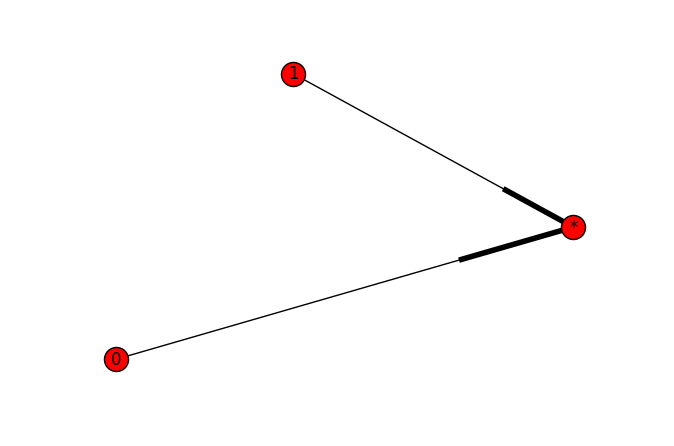

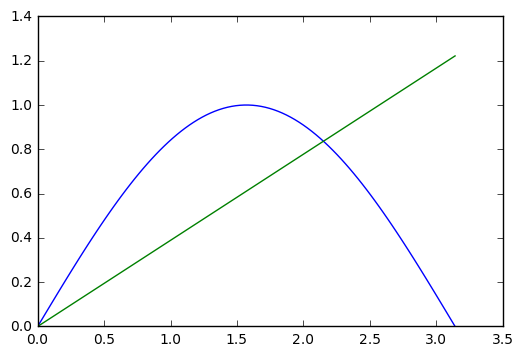

min error at generation n.0: 19.8869814336
evolving generation 1 of 2


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_her

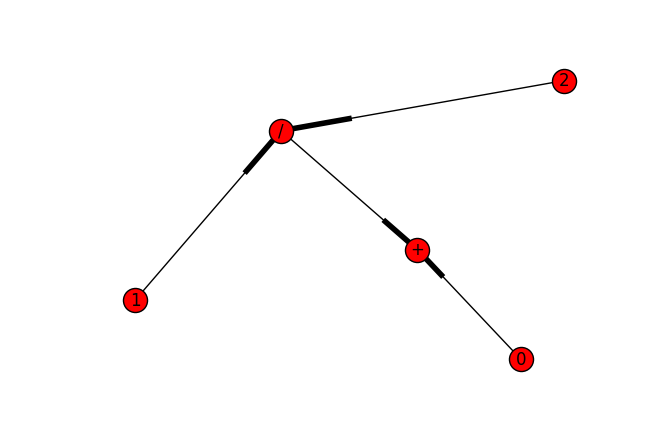

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON


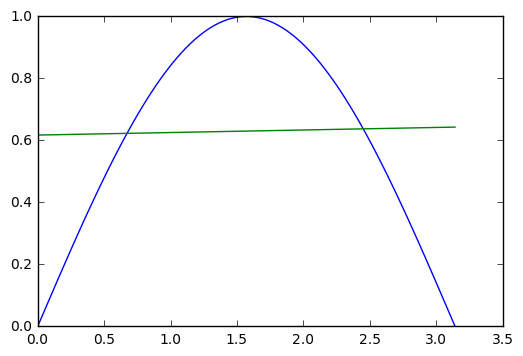

min error at generation n.1: 9.81688381348


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]


In [19]:
%lprun -f gradient evolution(data, 2)

evolving generation 0 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_her

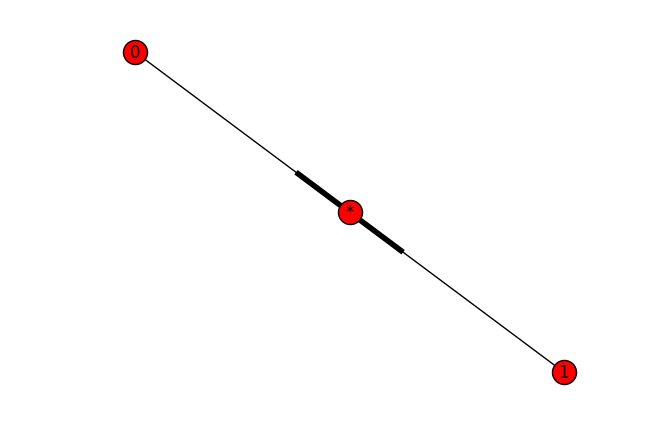

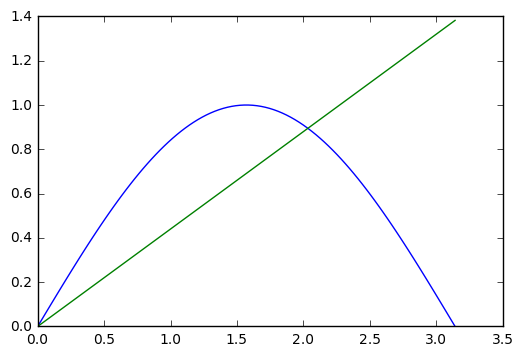

min error at generation n.0: 22.6693159691
evolving generation 1 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_her

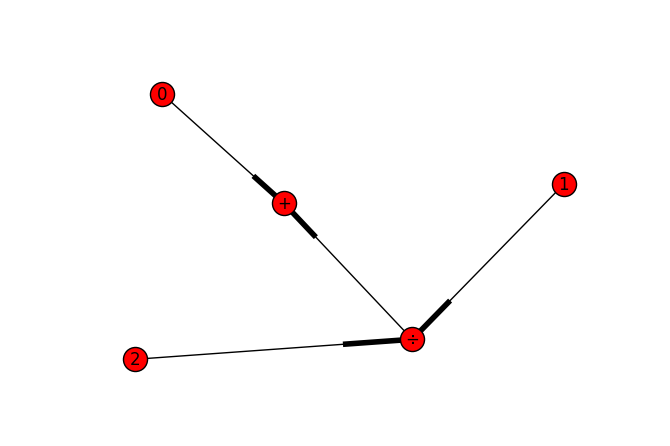

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:213: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON


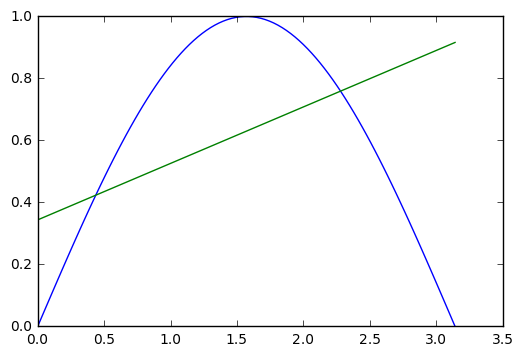

min error at generation n.1: 13.0718478306
evolving generation 2 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


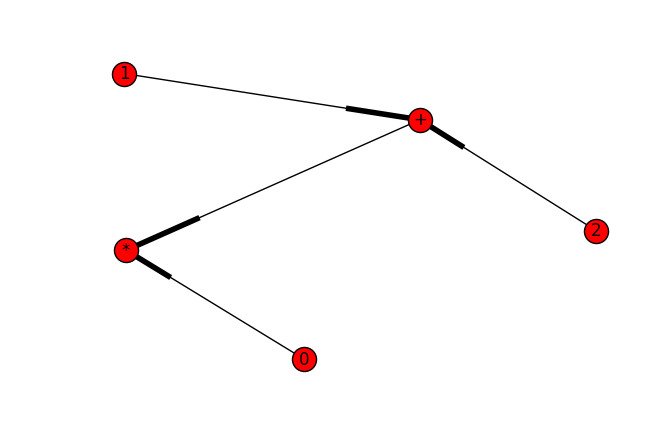

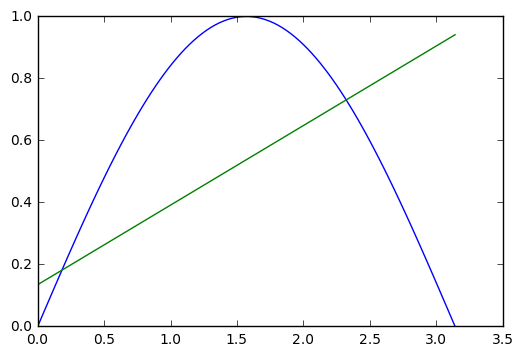

min error at generation n.2: 16.2439761749
evolving generation 3 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


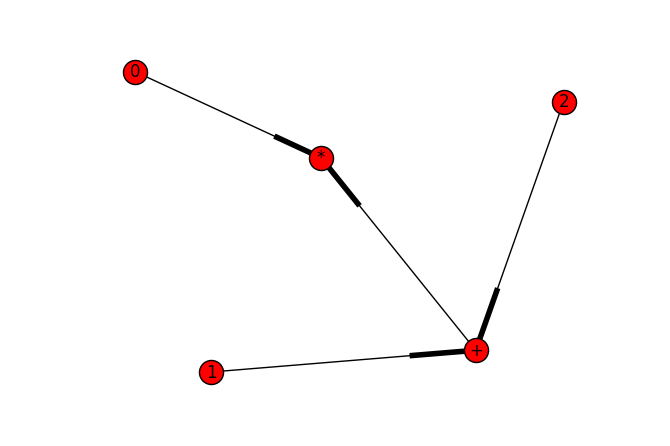

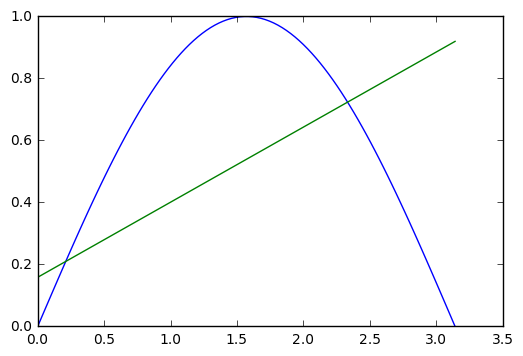

min error at generation n.3: 15.8097468495
evolving generation 4 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


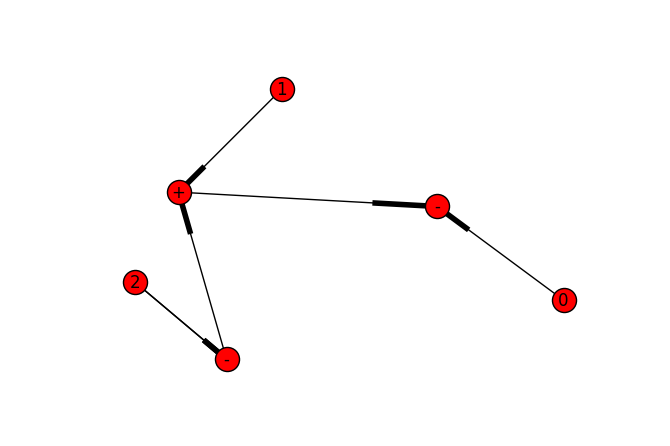

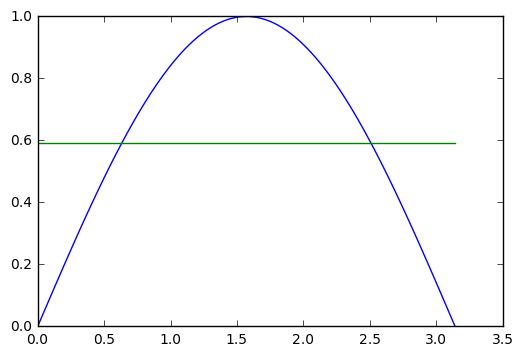

min error at generation n.4: 9.9675569194
evolving generation 5 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


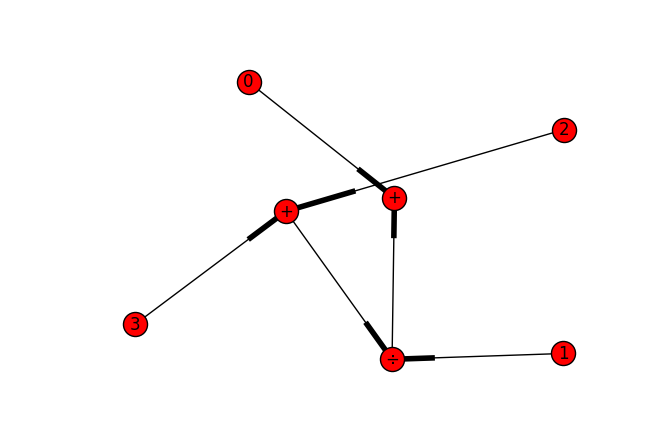

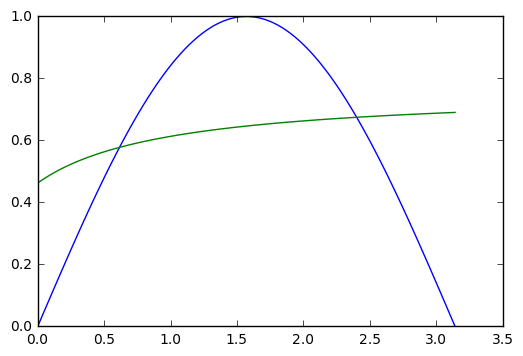

min error at generation n.5: 12.6621607418
evolving generation 6 of 100


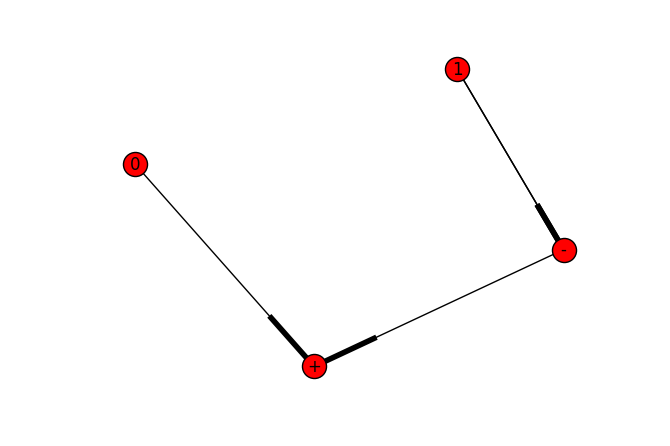

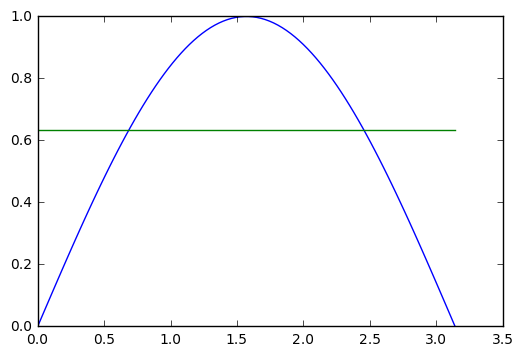

min error at generation n.6: 9.8449298946
evolving generation 7 of 100


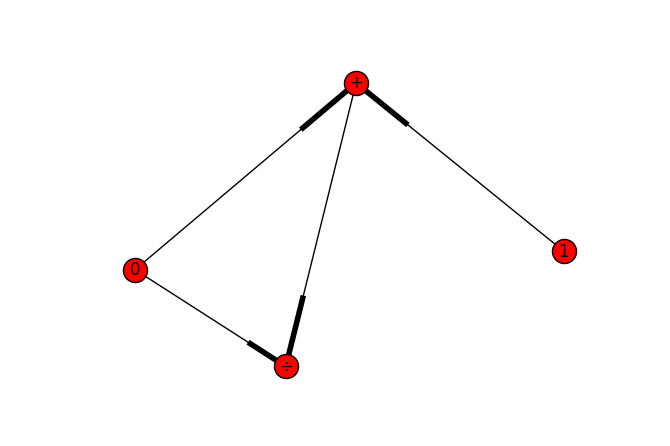

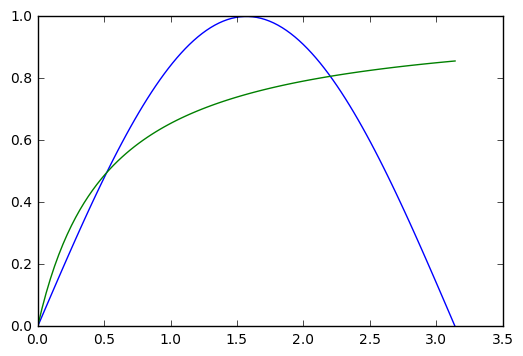

min error at generation n.7: 8.99959235526
evolving generation 8 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


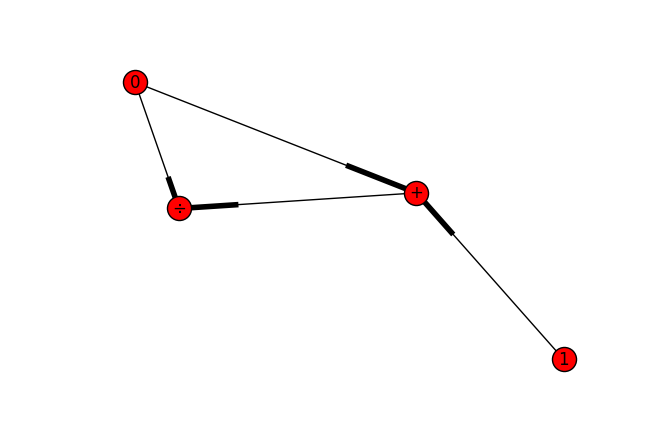

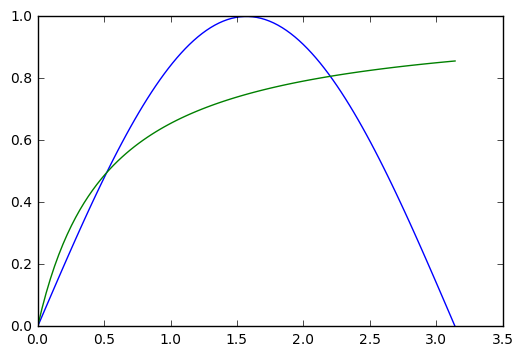

min error at generation n.8: 9.12350087501
evolving generation 9 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


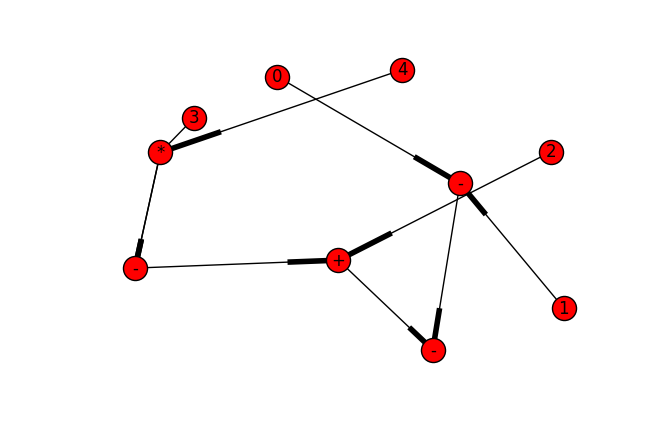

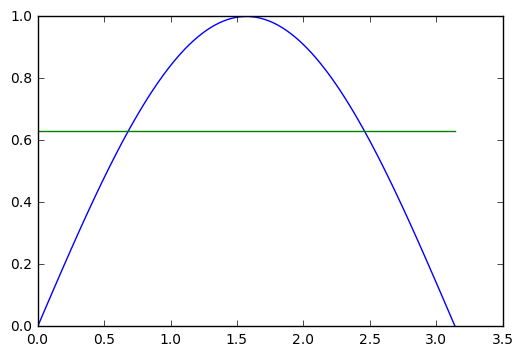

min error at generation n.9: 9.89327856199
evolving generation 10 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


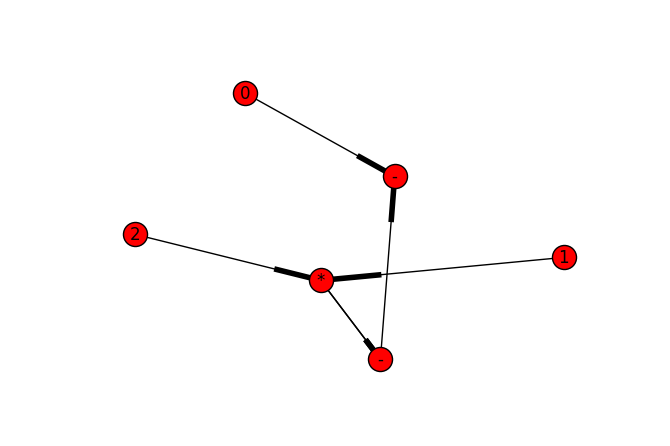

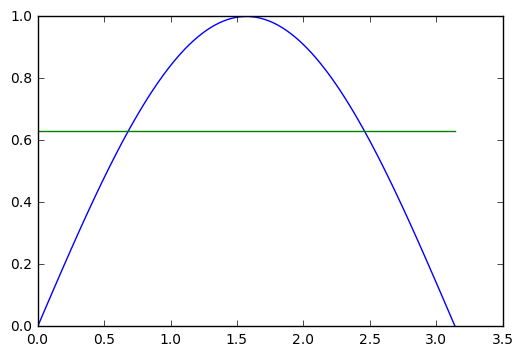

min error at generation n.10: 9.92841623298
evolving generation 11 of 100


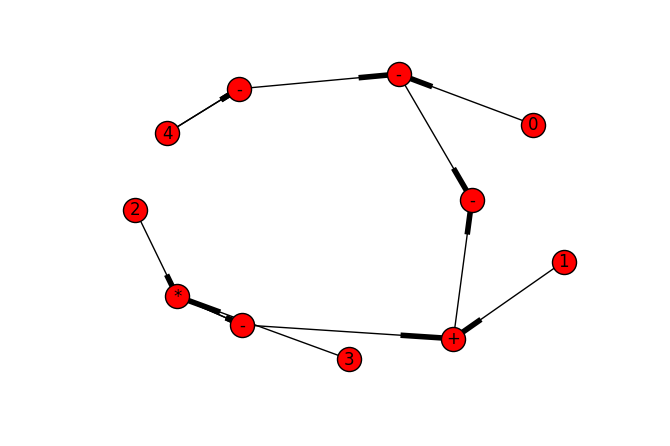

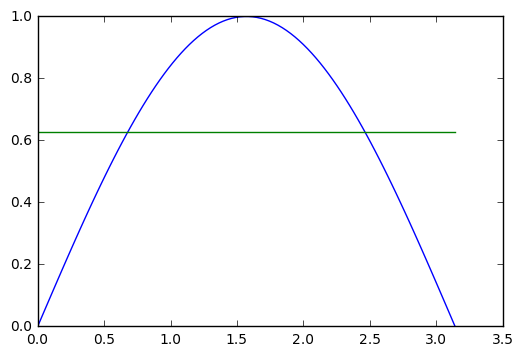

min error at generation n.11: 10.0445890399
evolving generation 12 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


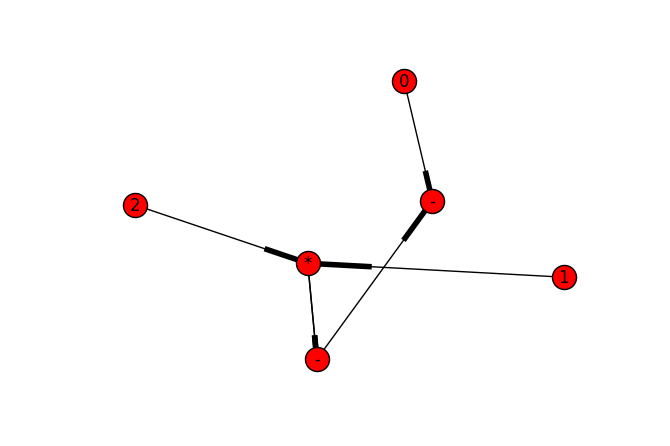

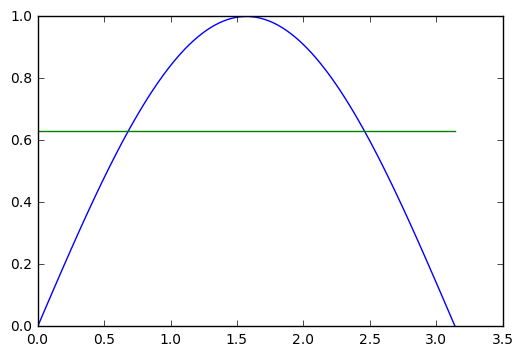

min error at generation n.12: 9.96472890376
evolving generation 13 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


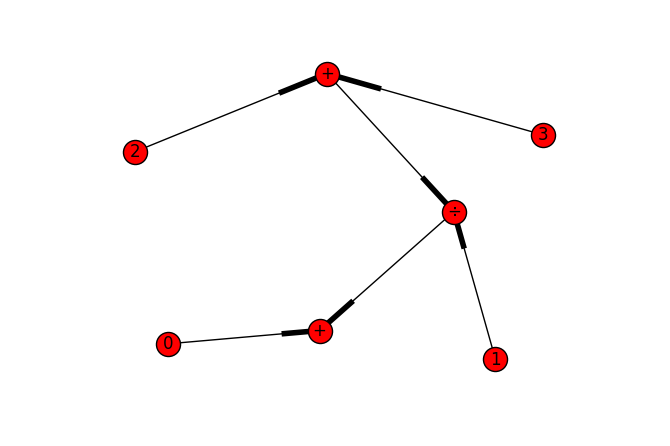

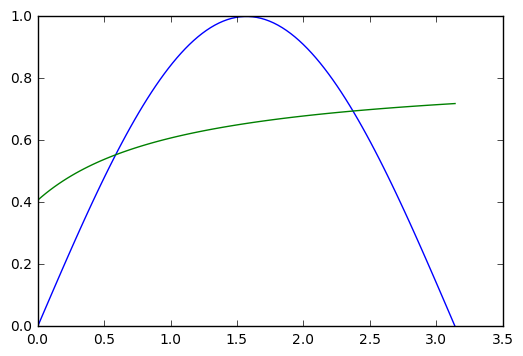

min error at generation n.13: 8.25200103708
evolving generation 14 of 100


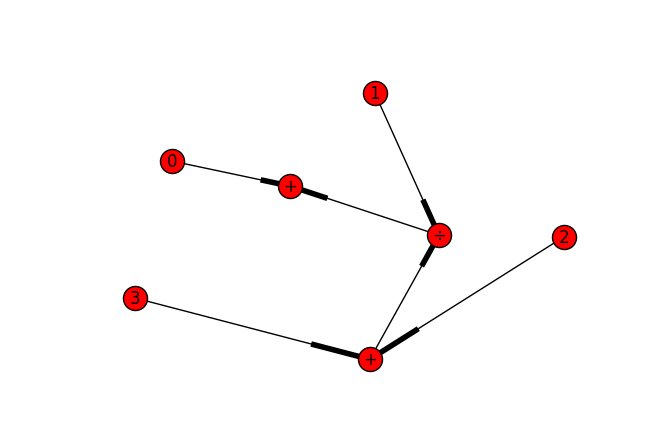

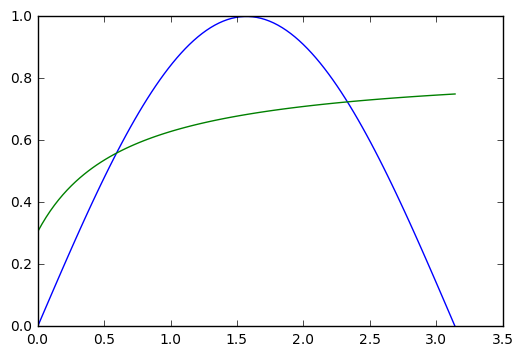

min error at generation n.14: 9.97330784959
evolving generation 15 of 100


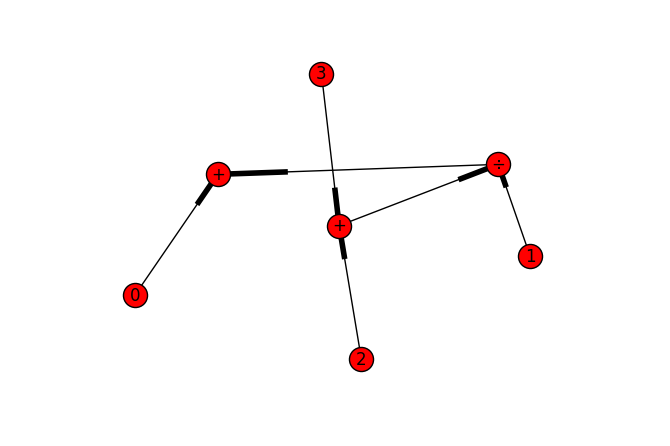

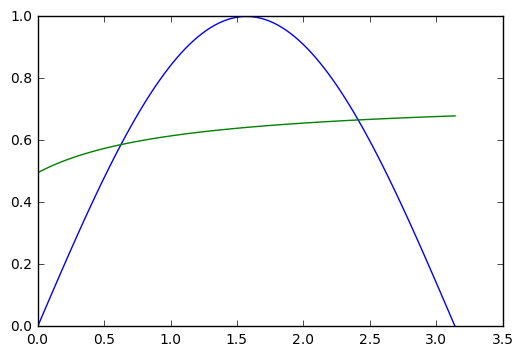

min error at generation n.15: 8.55697779956
evolving generation 16 of 100


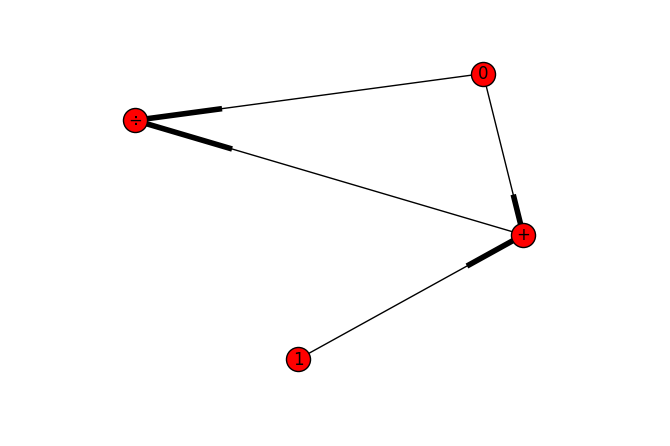

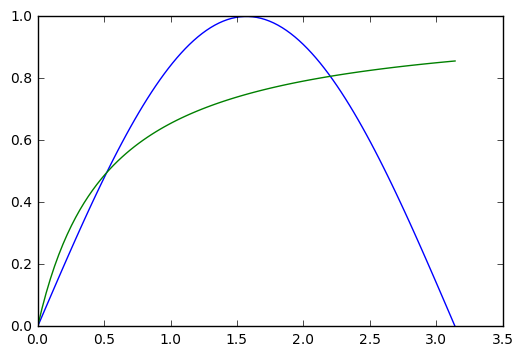

min error at generation n.16: 8.92681746818
evolving generation 17 of 100


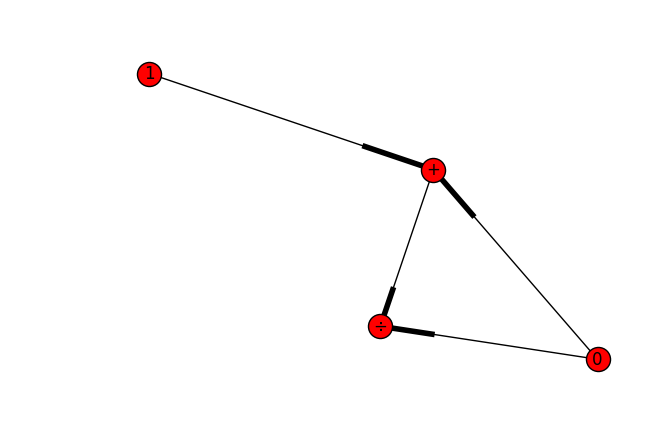

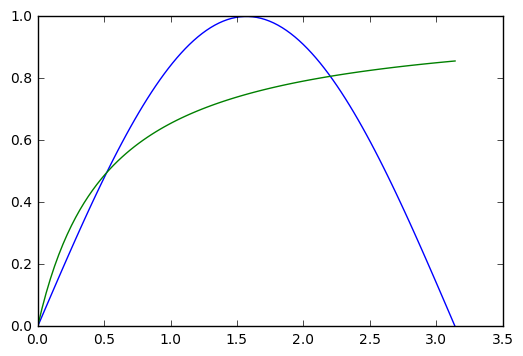

min error at generation n.17: 8.89895587303
evolving generation 18 of 100


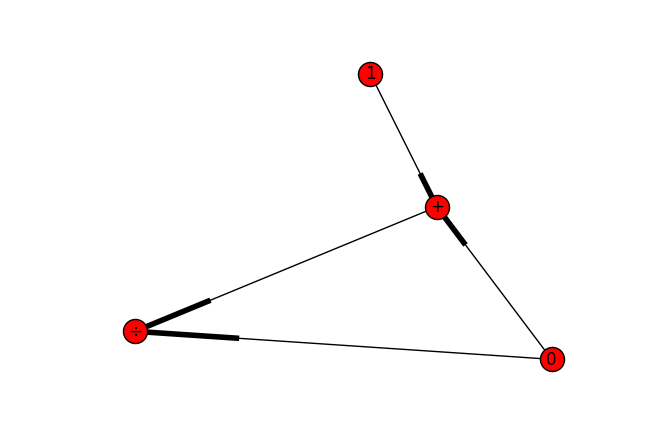

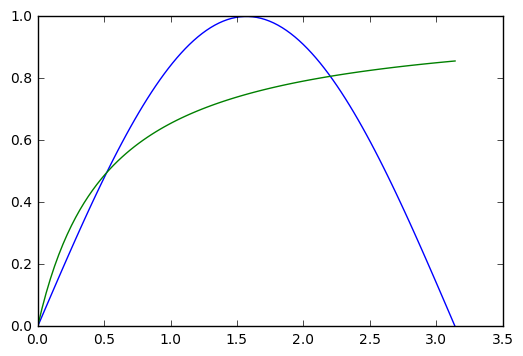

min error at generation n.18: 9.05909686424
evolving generation 19 of 100


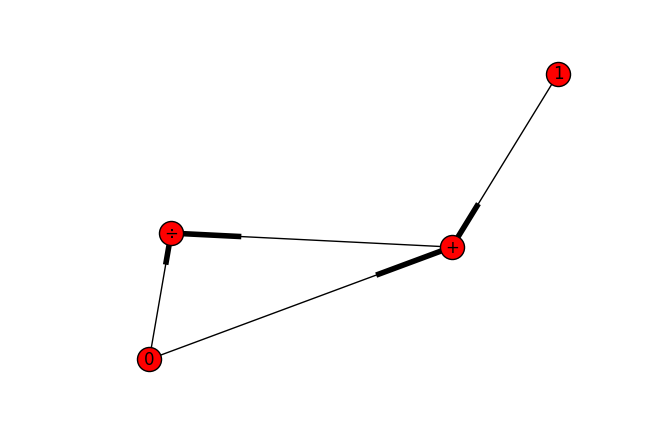

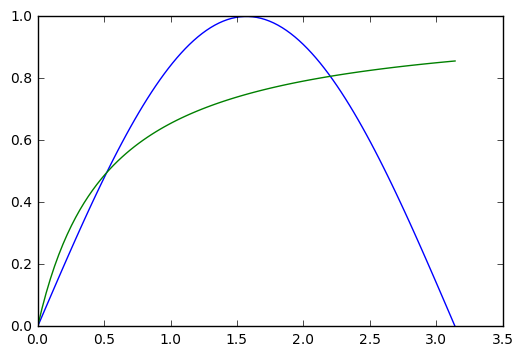

min error at generation n.19: 8.90454917289
evolving generation 20 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


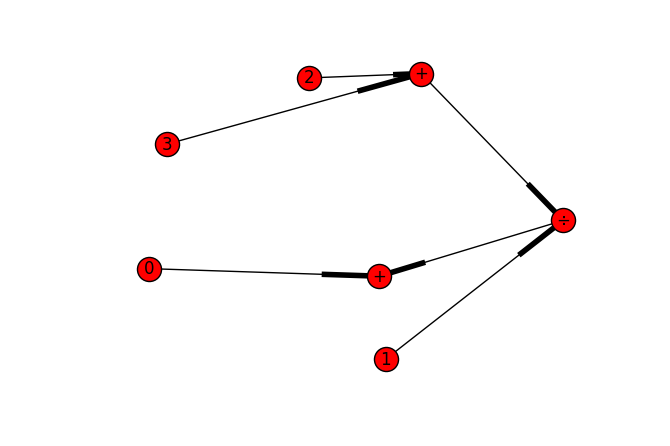

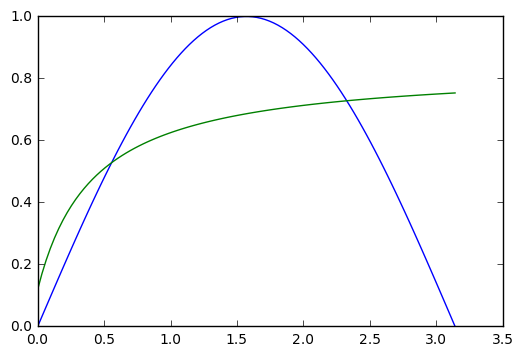

min error at generation n.20: 8.84103017537
evolving generation 21 of 100


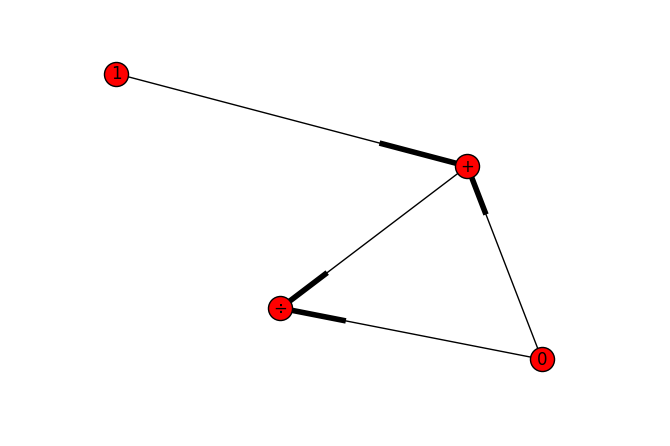

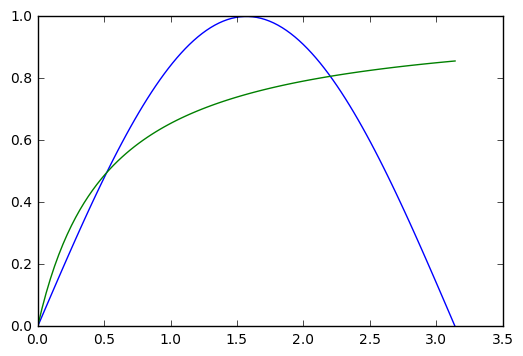

min error at generation n.21: 8.95114808418
evolving generation 22 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


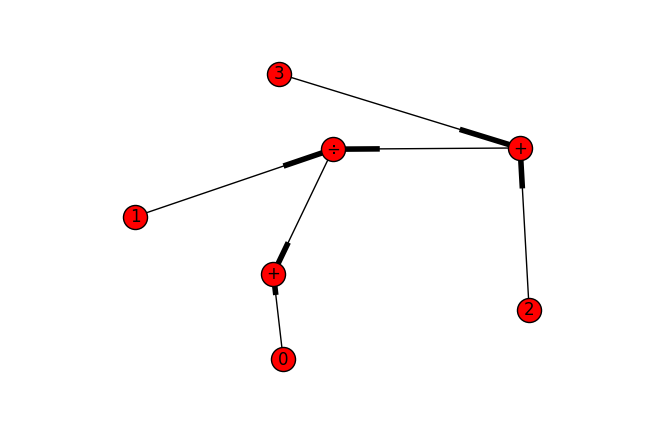

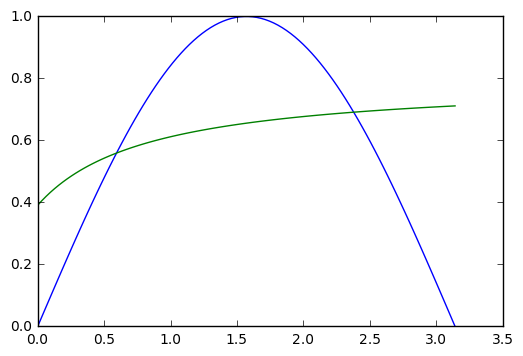

min error at generation n.22: 8.4698241941
evolving generation 23 of 100


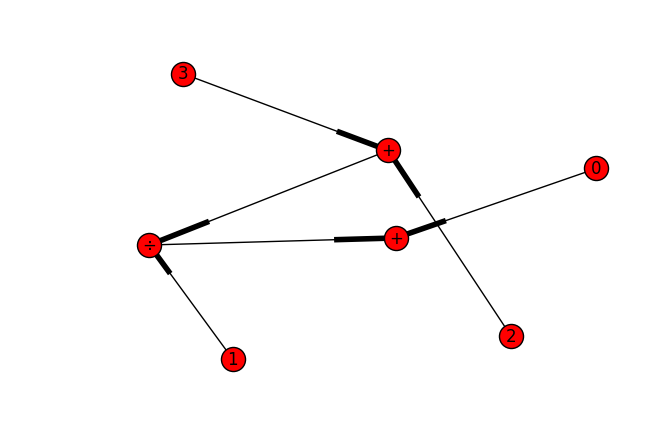

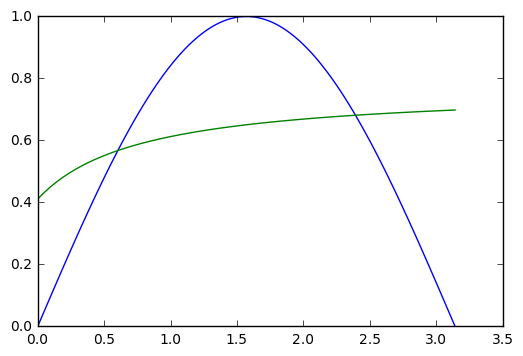

min error at generation n.23: 8.62486743539
evolving generation 24 of 100


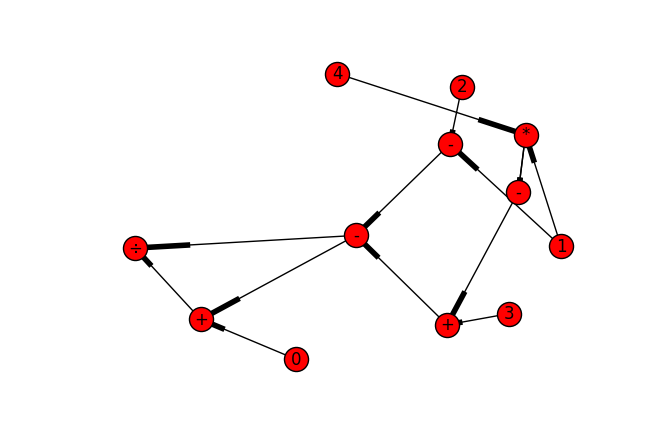

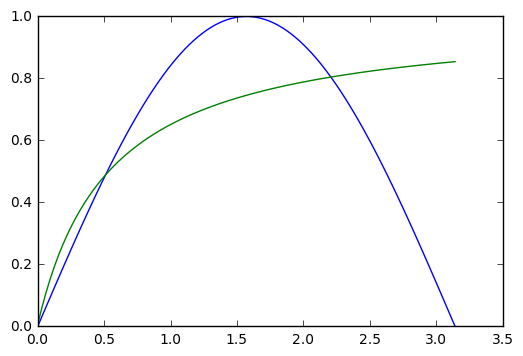

min error at generation n.24: 9.36275657723
evolving generation 25 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


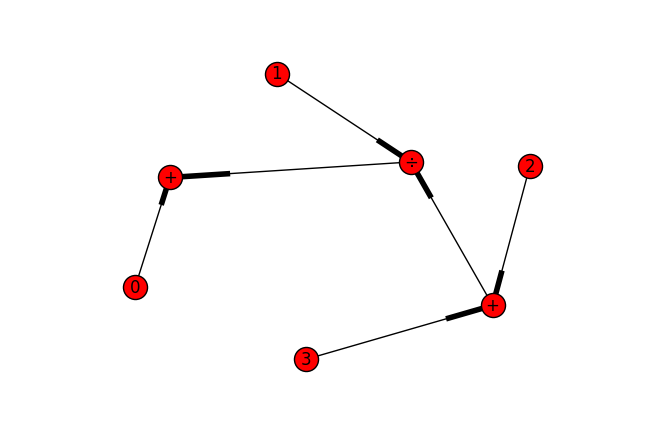

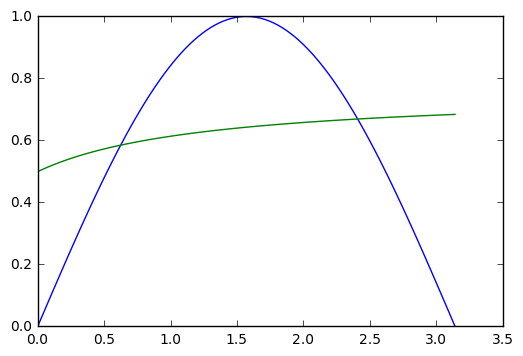

min error at generation n.25: 9.5656911838
evolving generation 26 of 100


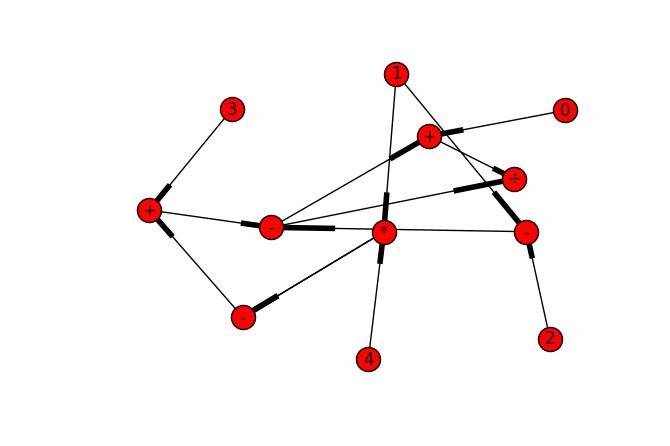

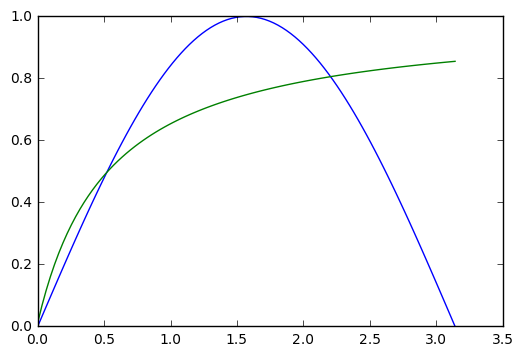

min error at generation n.26: 9.25244235456
evolving generation 27 of 100


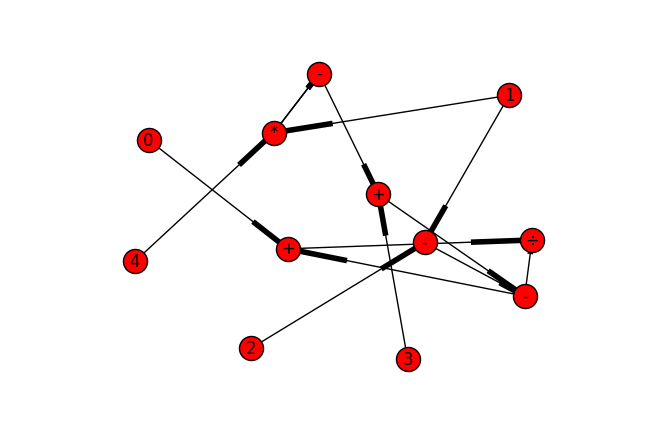

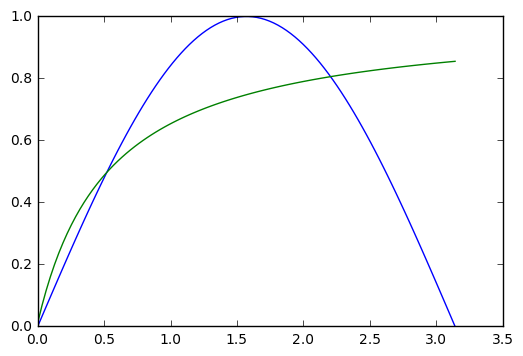

min error at generation n.27: 9.26763001383
evolving generation 28 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


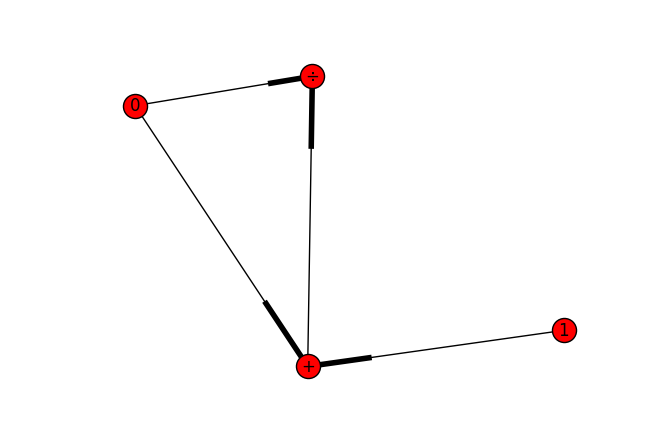

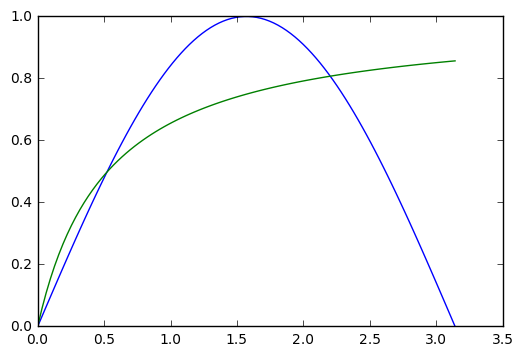

min error at generation n.28: 8.94629865028
evolving generation 29 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


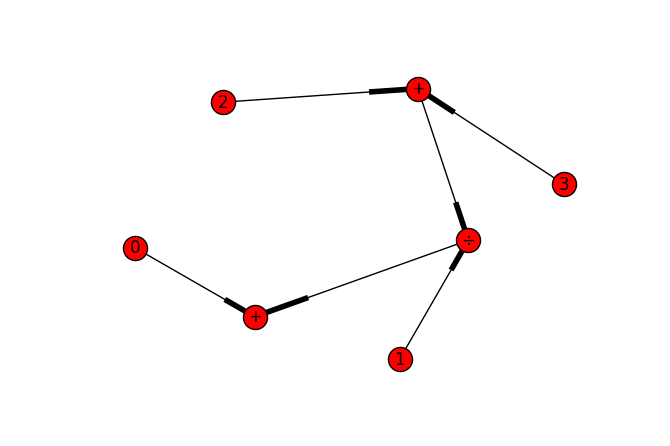

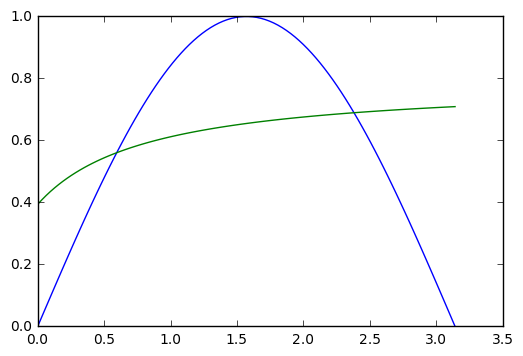

min error at generation n.29: 9.34035476426
evolving generation 30 of 100


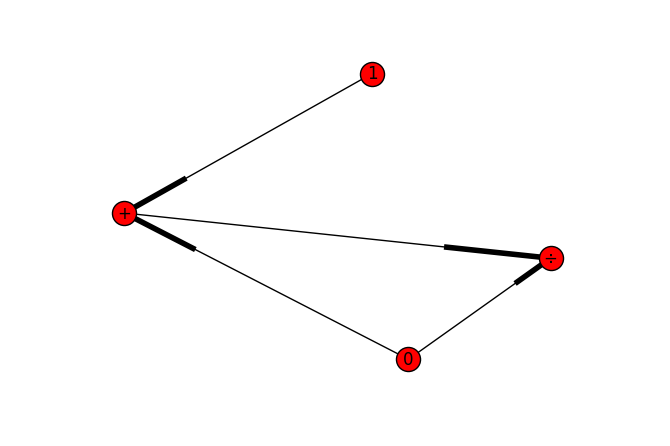

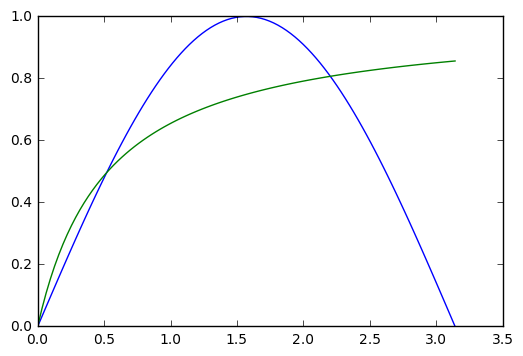

min error at generation n.30: 8.94356875755
evolving generation 31 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


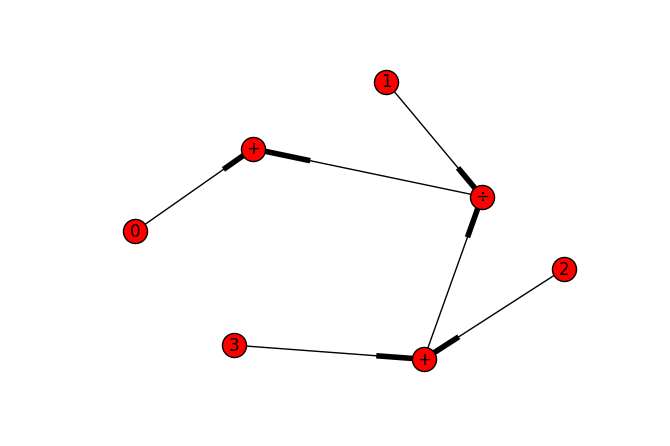

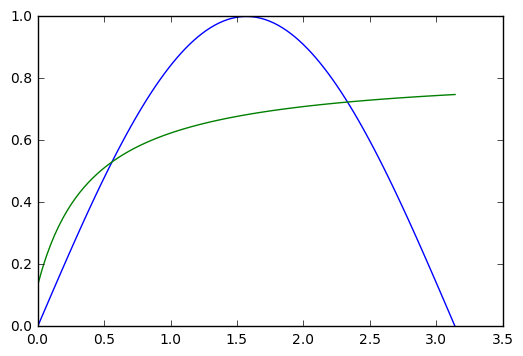

min error at generation n.31: 7.8903092512
evolving generation 32 of 100


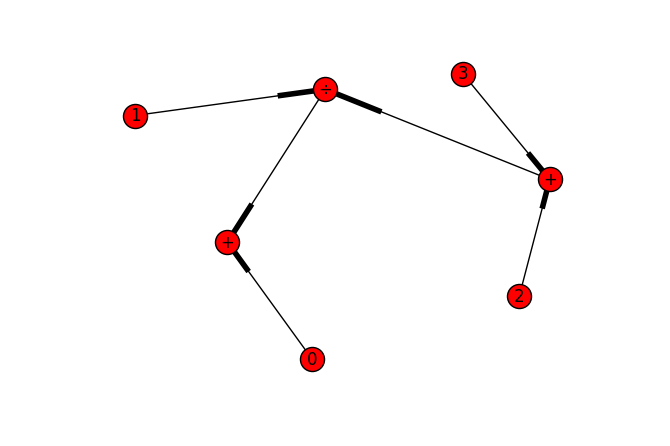

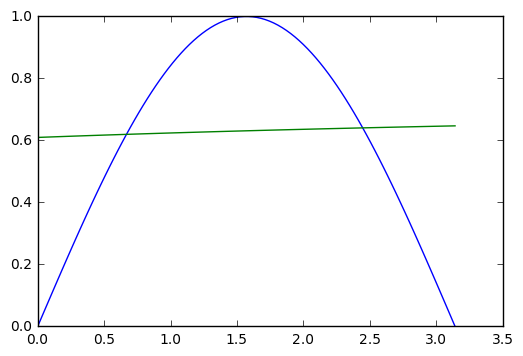

min error at generation n.32: 8.1733851373
evolving generation 33 of 100


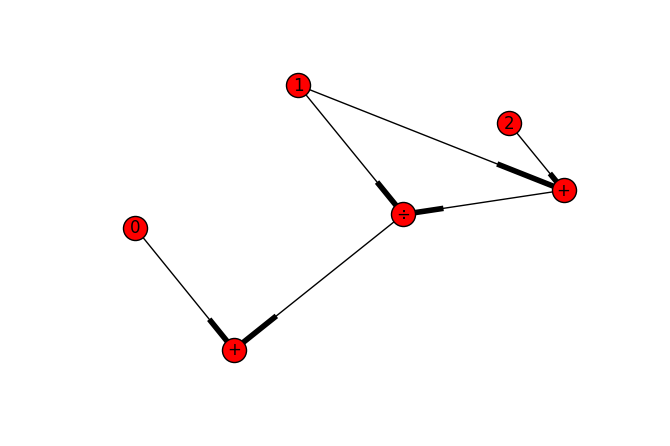

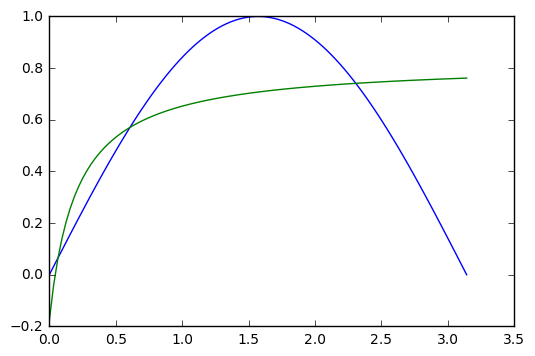

min error at generation n.33: 8.76601834428
evolving generation 34 of 100


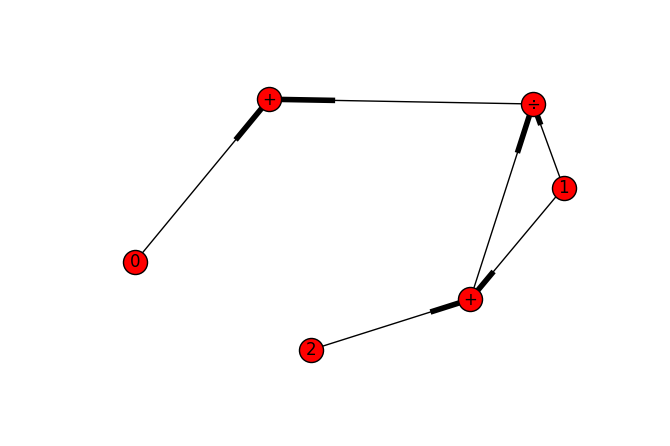

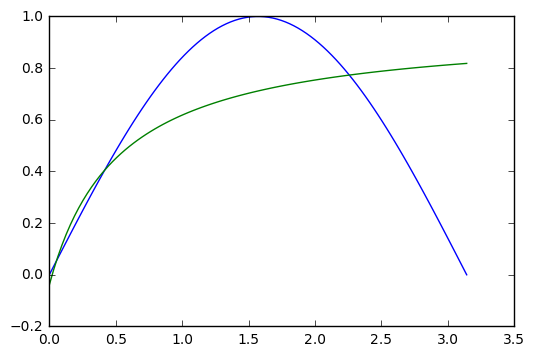

min error at generation n.34: 8.75121162119
evolving generation 35 of 100


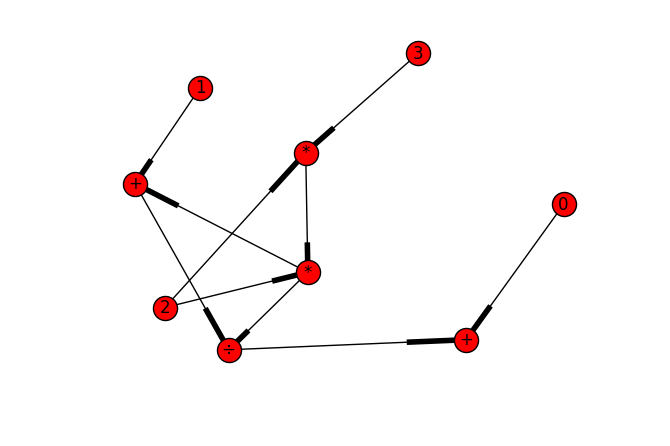

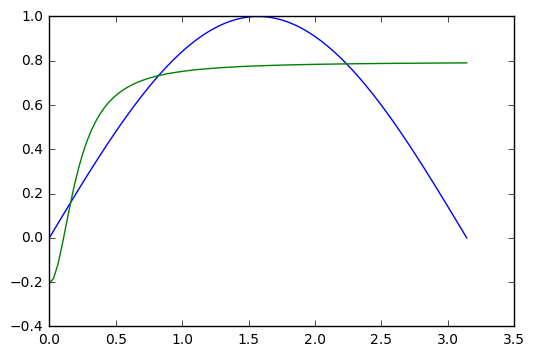

min error at generation n.35: 7.08404579254
evolving generation 36 of 100


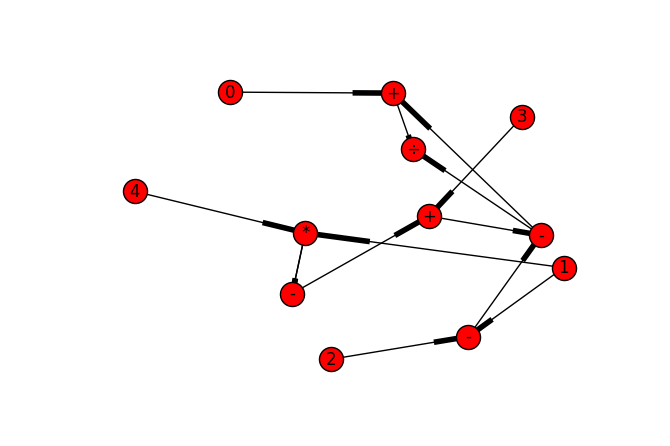

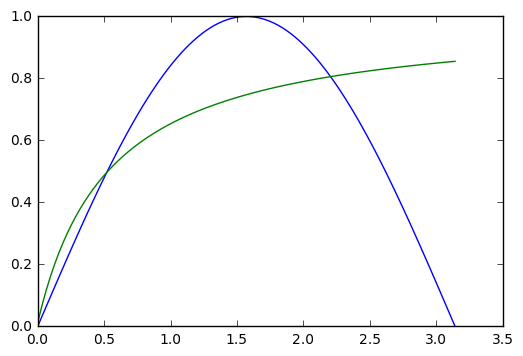

min error at generation n.36: 10.5604431874
evolving generation 37 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


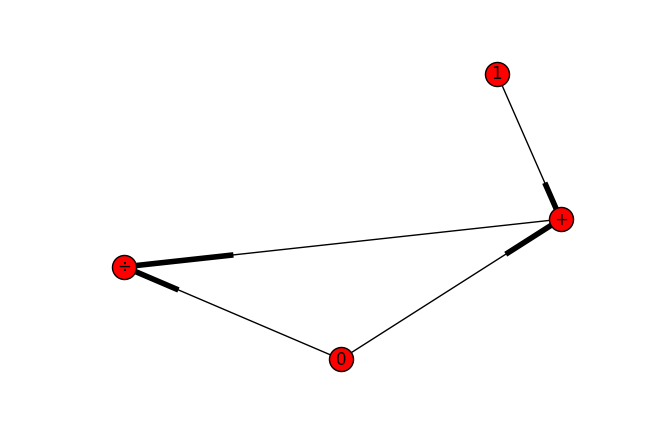

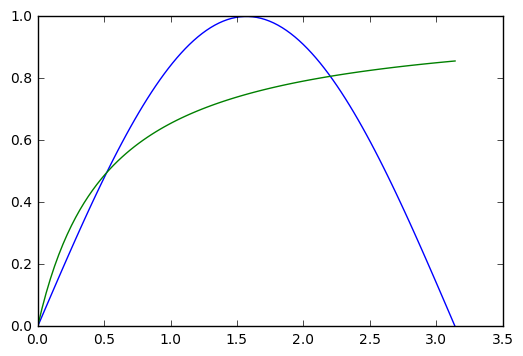

min error at generation n.37: 8.91322760917
evolving generation 38 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


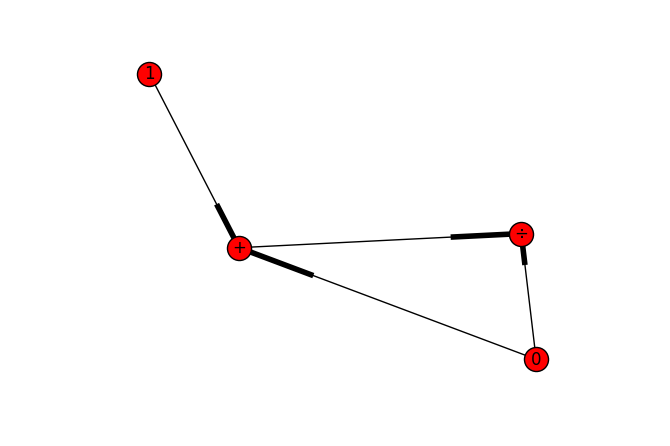

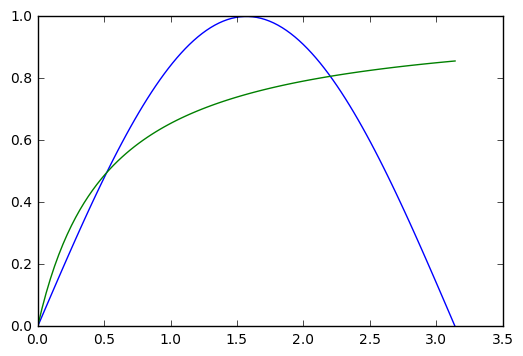

min error at generation n.38: 8.87329011299
evolving generation 39 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


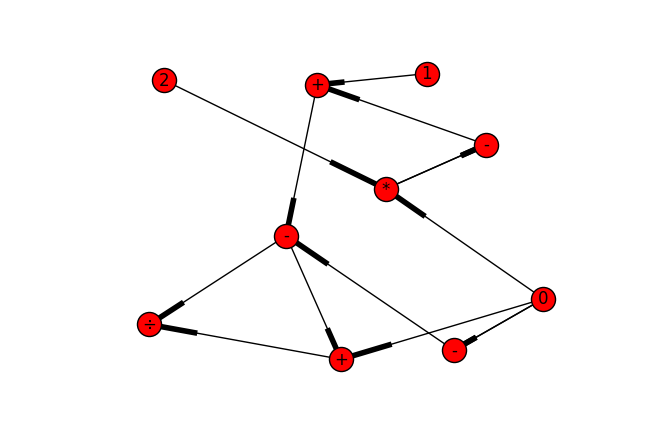

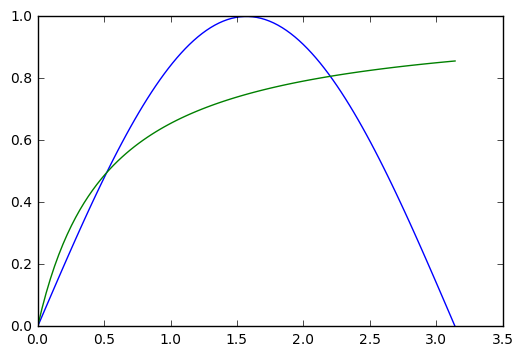

min error at generation n.39: 9.09166245797
evolving generation 40 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


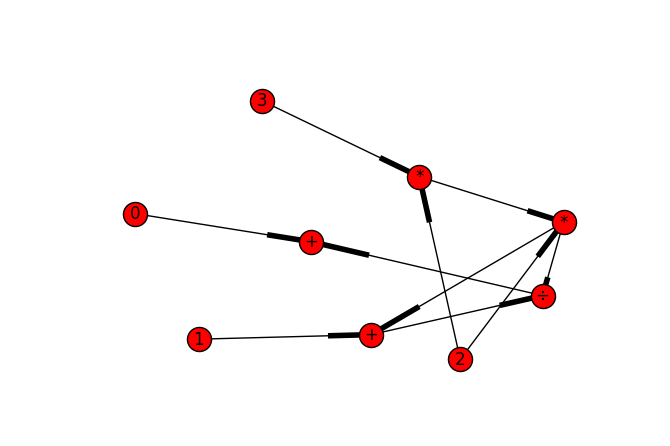

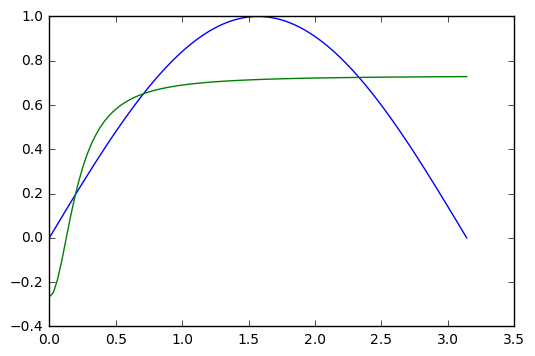

min error at generation n.40: 10.0349029736
evolving generation 41 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


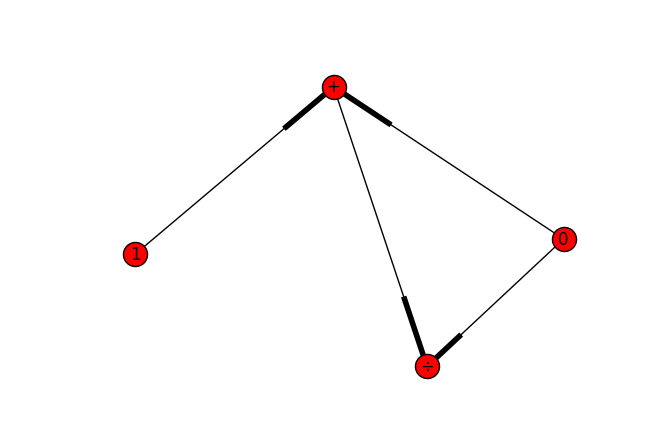

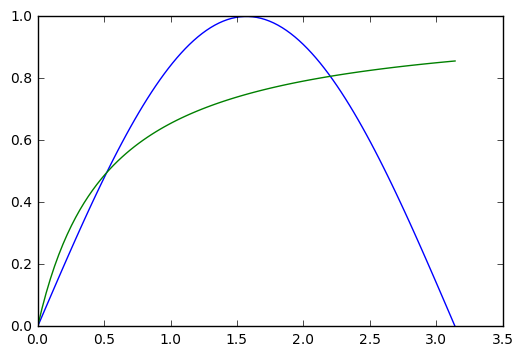

min error at generation n.41: 8.88709216453
evolving generation 42 of 100


/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]
/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


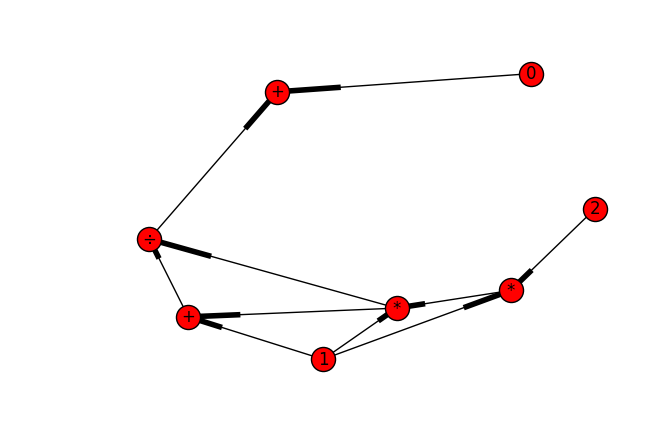

/media/Stuff/Desktop/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in true_divide
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"÷"}]


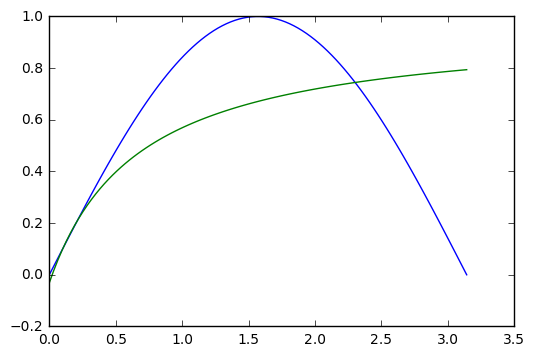

min error at generation n.42: 10.1934585101
evolving generation 43 of 100


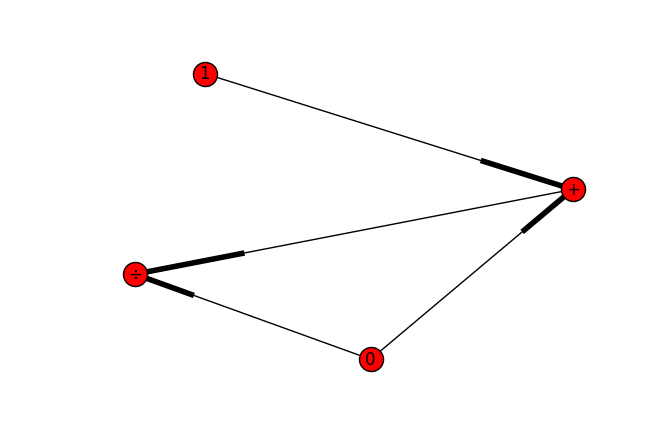

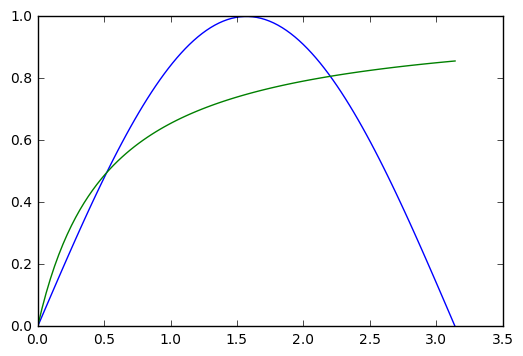

min error at generation n.43: 8.93146424629
evolving generation 44 of 100


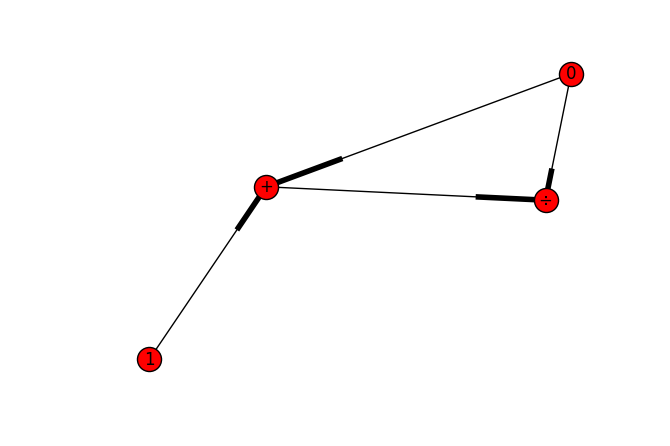

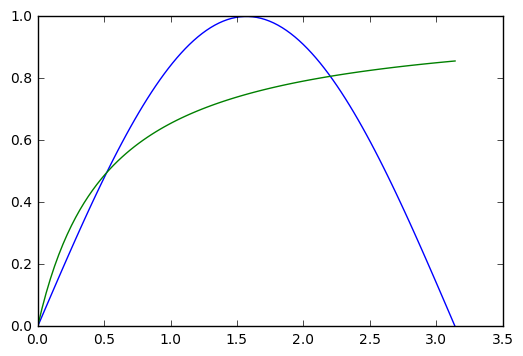

min error at generation n.44: 8.88621239997
evolving generation 45 of 100


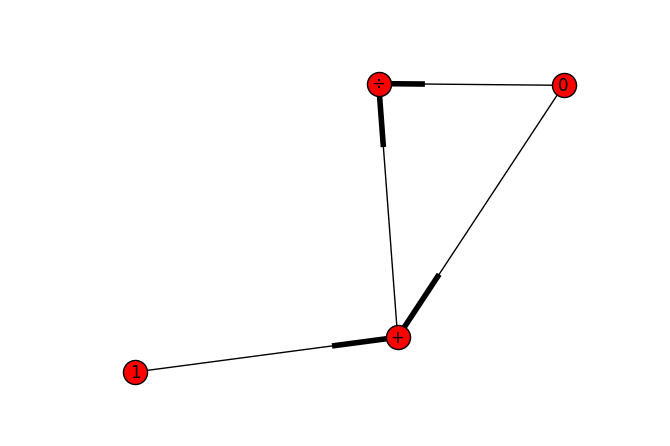

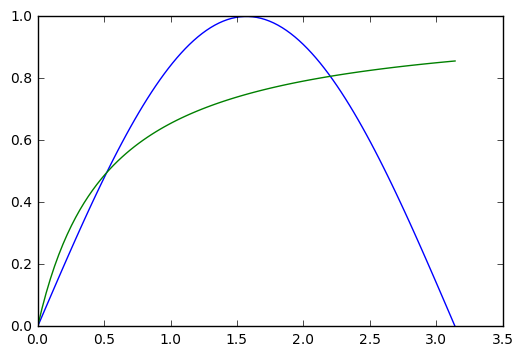

min error at generation n.45: 8.8964763198
evolving generation 46 of 100


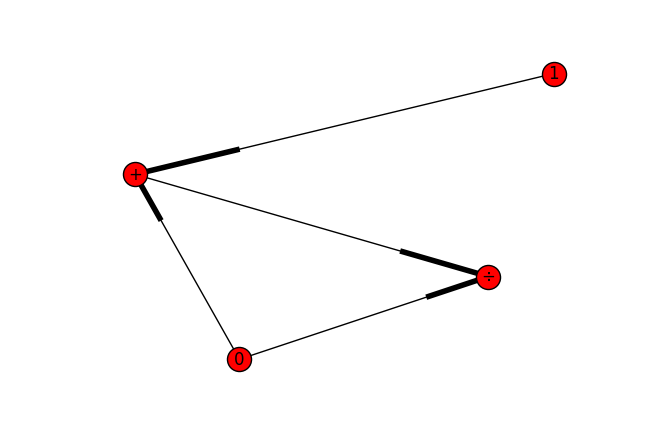

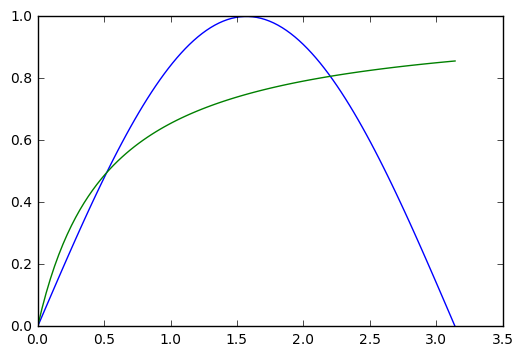

min error at generation n.46: 8.93512397148
evolving generation 47 of 100


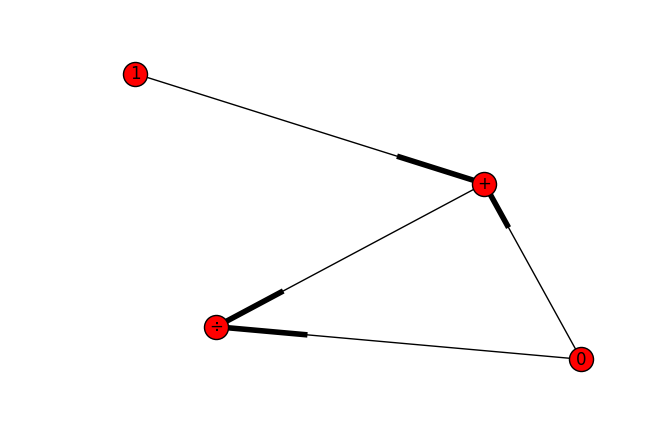

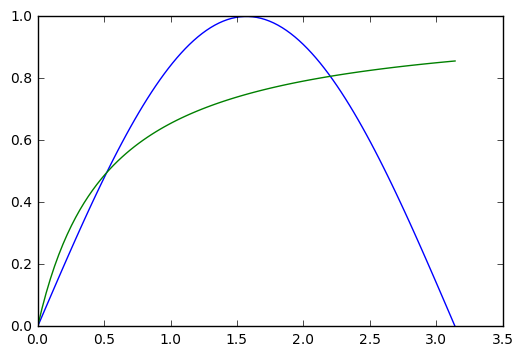

min error at generation n.47: 8.86064439155
evolving generation 48 of 100


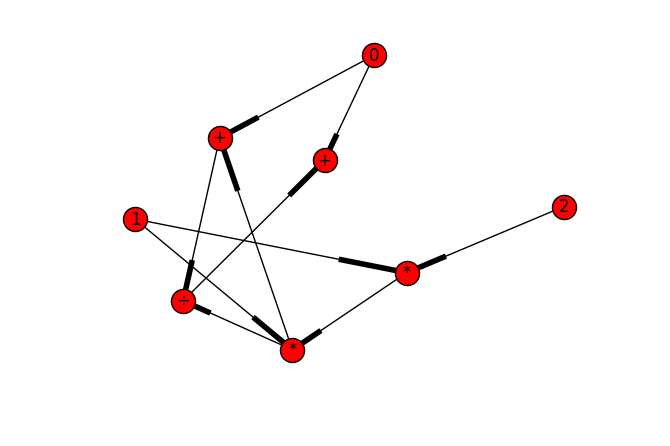

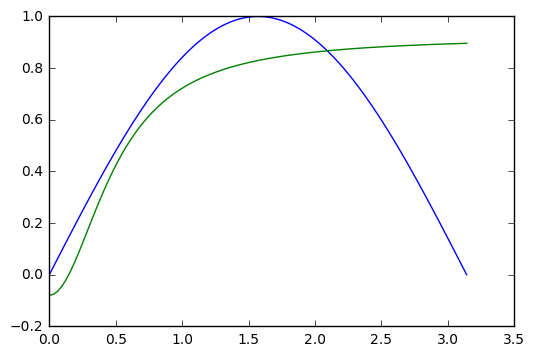

min error at generation n.48: 8.30287853412
evolving generation 49 of 100


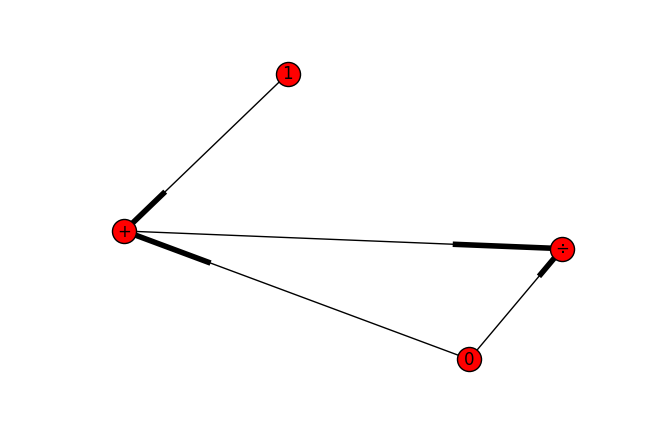

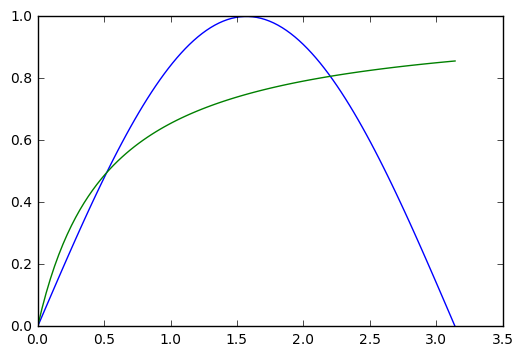

min error at generation n.49: 8.91761212684
evolving generation 50 of 100


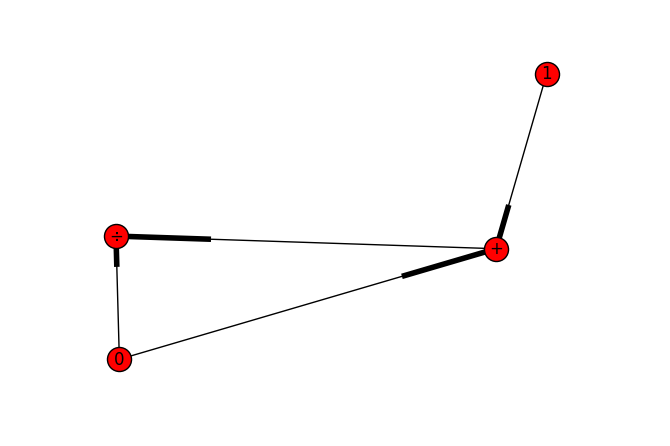

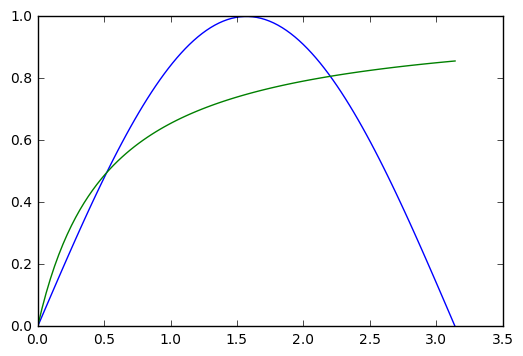

min error at generation n.50: 8.90499739982
evolving generation 51 of 100


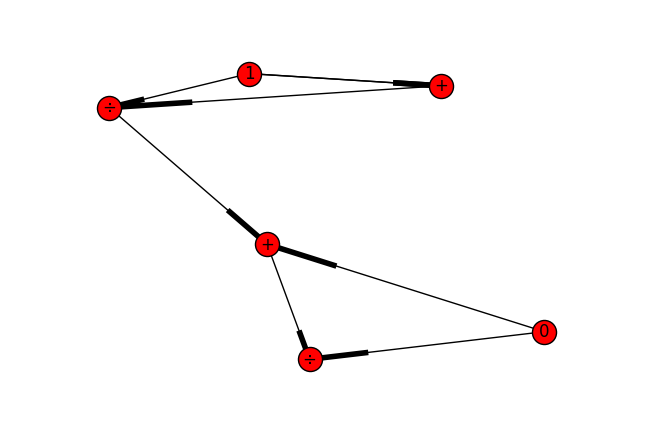

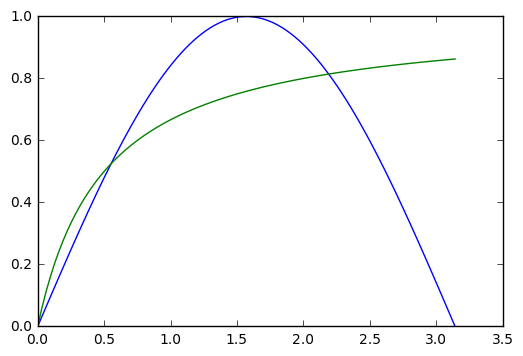

min error at generation n.51: 8.90714532975
evolving generation 52 of 100


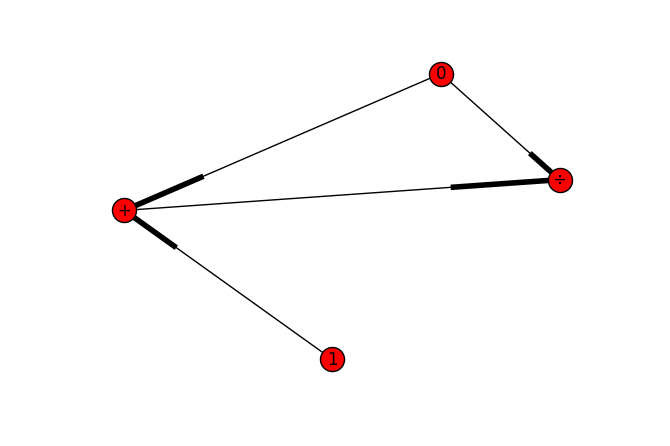

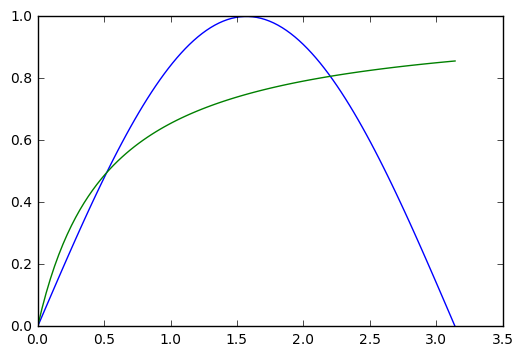

min error at generation n.52: 9.05556826927
evolving generation 53 of 100


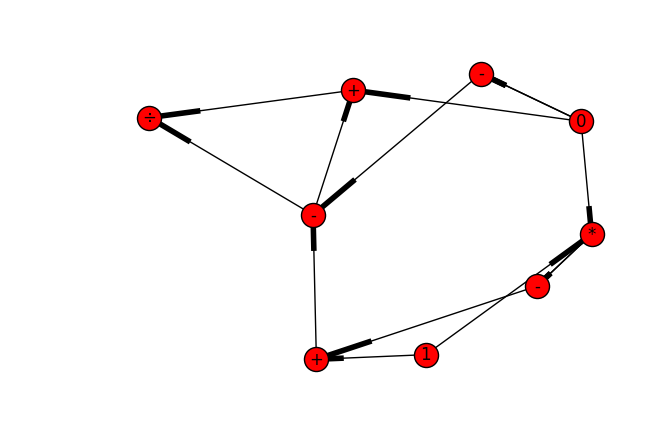

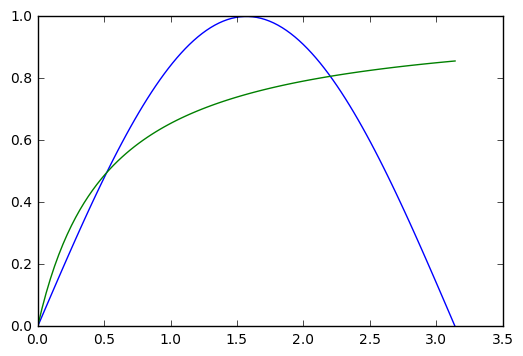

min error at generation n.53: 8.94185214378
evolving generation 54 of 100


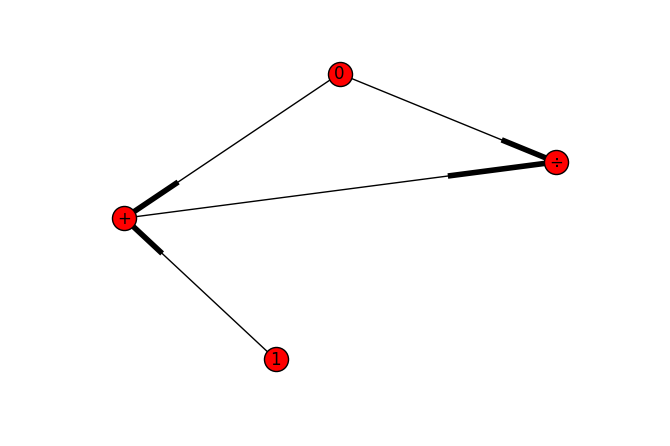

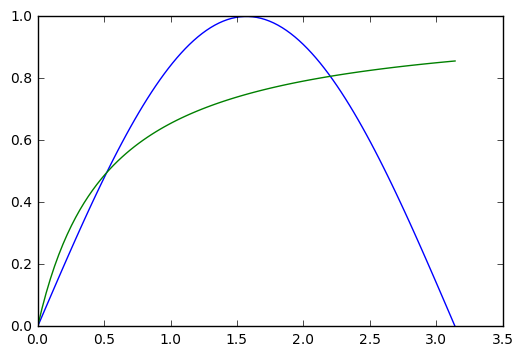

min error at generation n.54: 8.9488950286
evolving generation 55 of 100


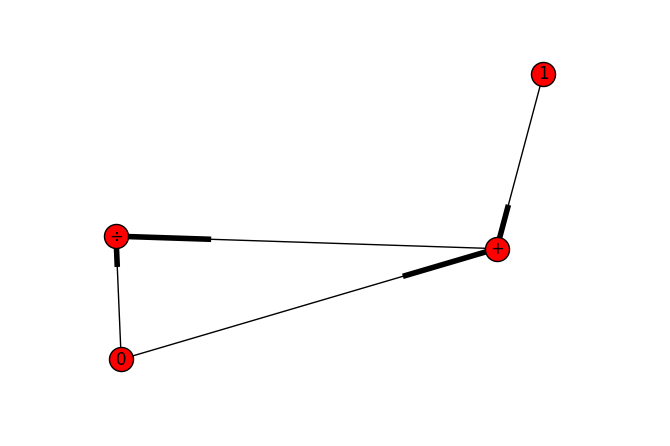

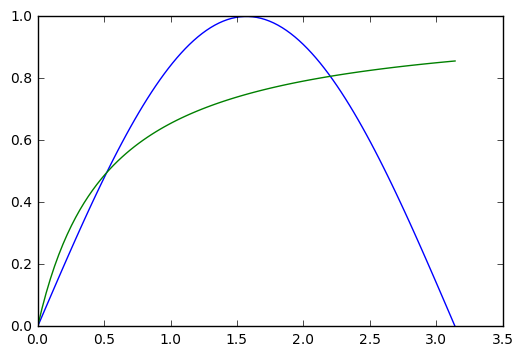

min error at generation n.55: 8.89387994148
evolving generation 56 of 100


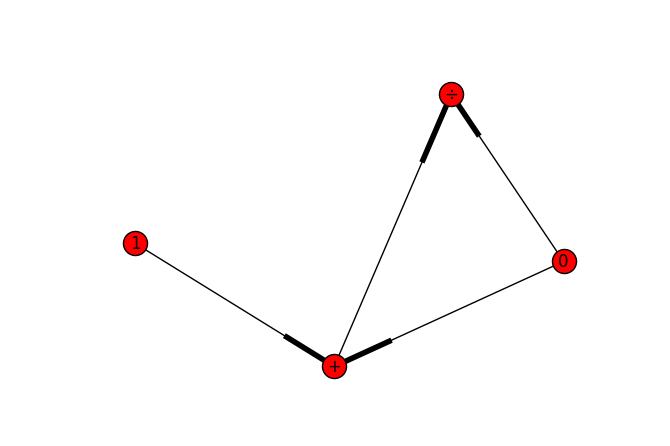

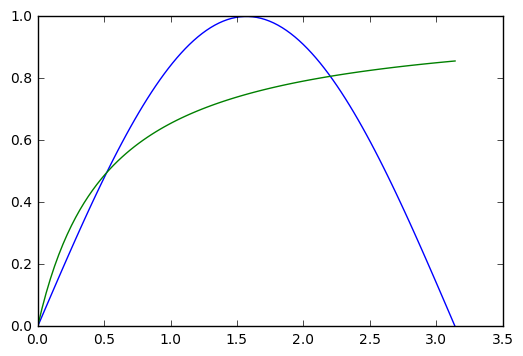

min error at generation n.56: 8.92512082955
evolving generation 57 of 100


In [ ]:
%%time
e = evolution(data, 100)
print(e)
# Export resulting graph to json file
# You can view it by starting a webserver(python2 -m SimpleHTTPServer) and then going to http://localhost:8000/graph_viewer.html
export_json_graph(e["specimen"])
print("fittest specimen:")
draw(e["specimen"])
plot_optimized(e["specimen"],data)

In [22]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
%lprun -f optimize optimize(lib[7]["graph"],data,0)

{'iterations': 51, 'parameters': array([ 0.81006931,  2.04725724]), 'error': 7.5945441550180899, 'X': 0}


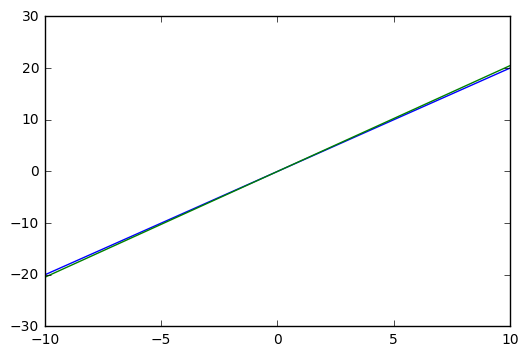

In [416]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
result = optimize(lib[7]["graph"],data,0)
print(result)
values = result["parameters"]
x_pos = result["X"]
#input_size*number_of_data_points matrix that contains a list of input vectors like [parameter1, parameter2, x_value, ...]
value_matrix = [[(xe if v == x_pos else value) for v, value in enumerate(values)] for xe in x]
y = np.array([ evaluate(lib[7]["graph"],value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

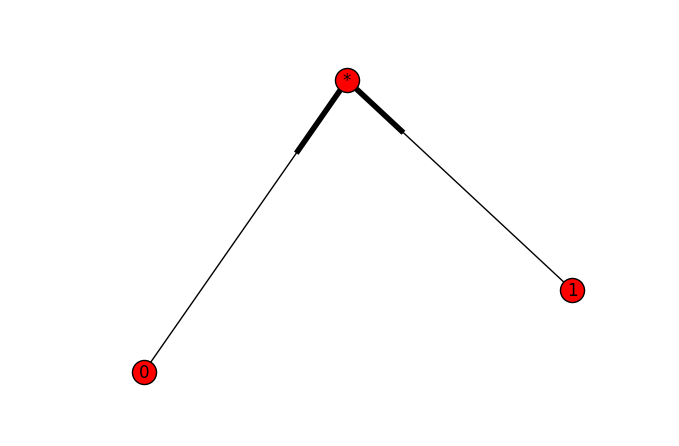

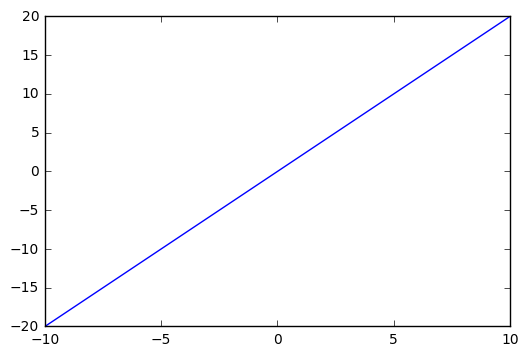

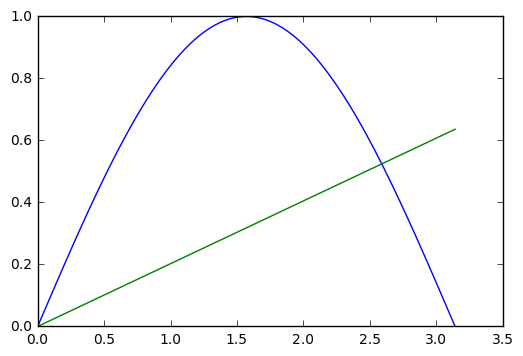

In [352]:
draw(lib[7]["graph"])
plot_specimen(lib[7]["graph"],[2,2])
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
plot_optimized(lib[7]["graph"],data)

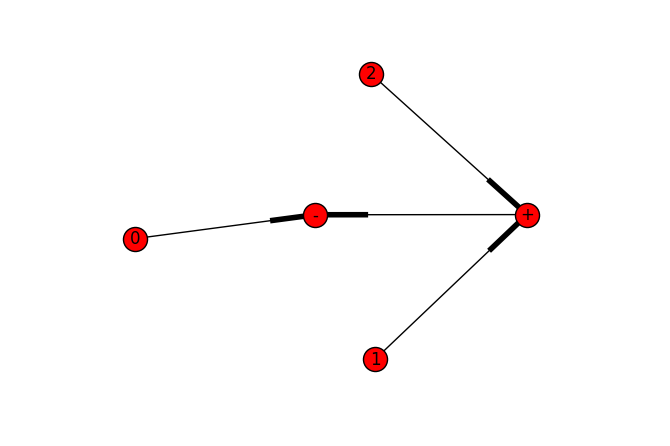

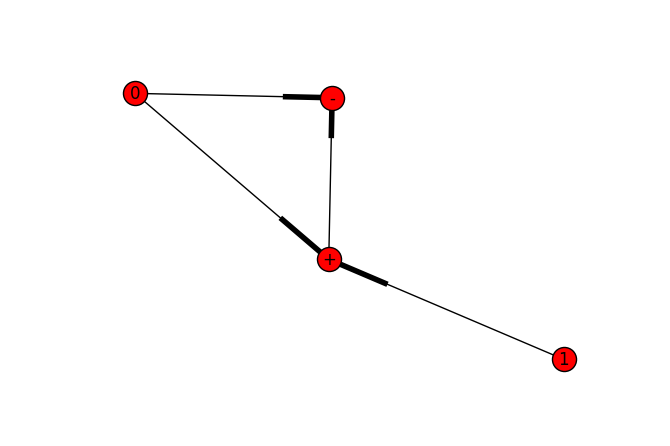

In [353]:
g3 = insert_at(lib[5]["graph"],lib[6]["graph"])
draw(g3)
g4 = merge_input_entries(g3)
draw(g4)

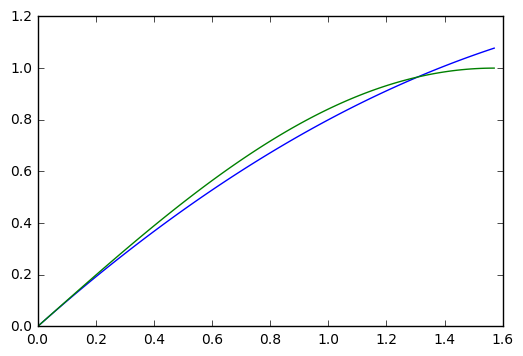

In [357]:
pylab.close()
x = np.linspace(0,math.pi/2,100)
y = x-0.2*x**2
pylab.plot(x,y)
y = np.sin(x)
pylab.plot(x,y)
pylab.show()